in:  [1.616463184, 1.482383013, 1.48063302, 1.564979553, 1.443571925]
in2:  [0.635422587, 0.626006722, 0.627162635, 0.620070577, 0.617950857]
out:  [7.537000179, 7.521999836, 7.504000187, 7.493999958, 7.468999863]


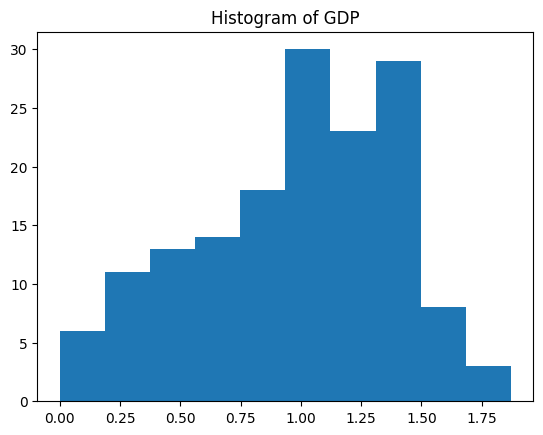

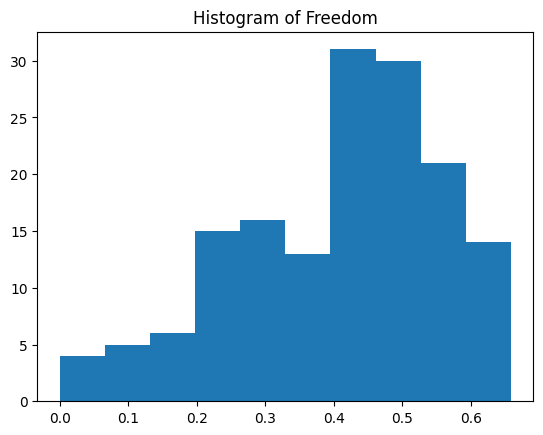

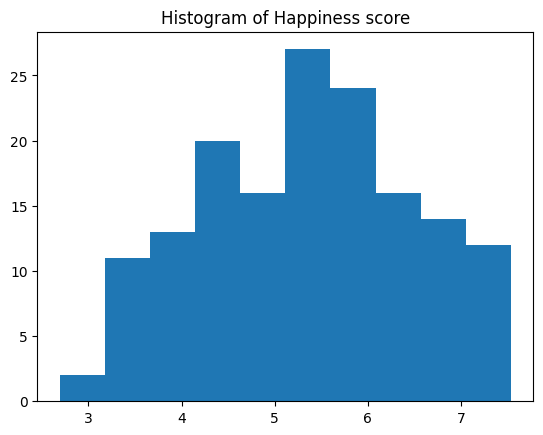

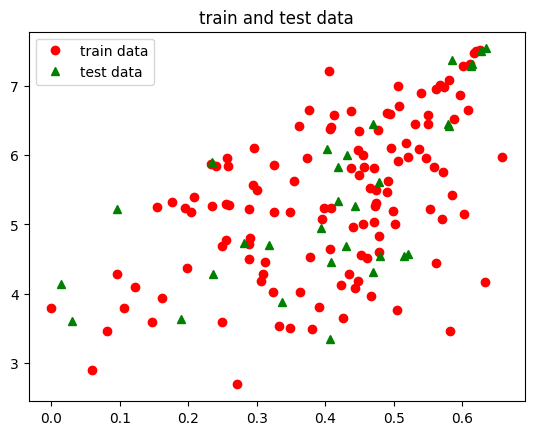

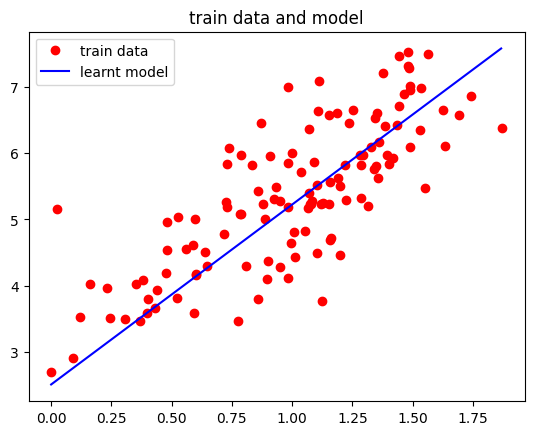

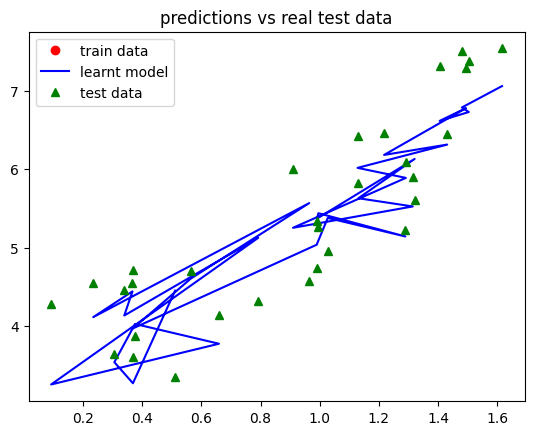

prediction error (manual):  0.2767262465302119
prediction error (tool):  0.2767262465302119


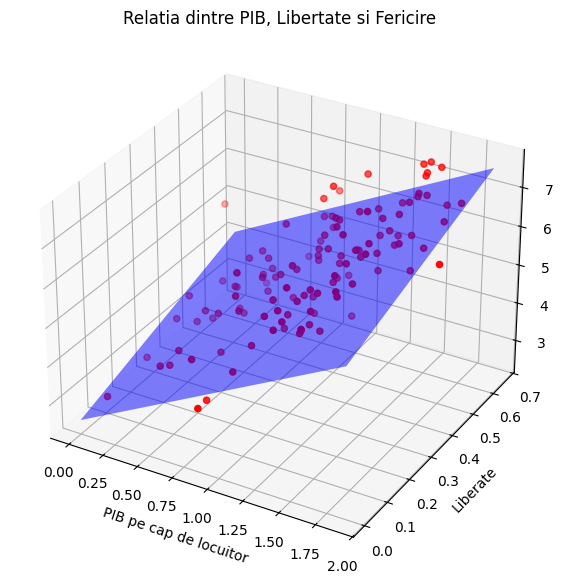

In [7]:
import csv
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Incarcam datele din csv
def loadData(fileName, inputVariabName1, inputVariableName2, outputVariabName):
    data = []
    dataNames = []
    with open(fileName) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                dataNames = row
            else:
                data.append(row)
            line_count += 1
            
    # Gasim indicii coloanelor
    selectedVariable = dataNames.index(inputVariabName1)
    selectedVariable2 = dataNames.index(inputVariableName2)
    selectedOutput = dataNames.index(outputVariabName)
    
    # Extragem valorile ca siruri initial, pentru a gestiona celulele goale
    raw_inputs = [data[i][selectedVariable] for i in range(len(data))]
    raw_inputs2 = [data[i][selectedVariable2] for i in range(len(data))]
    raw_outputs = [data[i][selectedOutput] for i in range(len(data))]
    
    # Convertim in float si calculam media, ignorand celulele goale
    inputs = [float(x) if x != "" else None for x in raw_inputs]
    inputs2 = [float(x) if x != "" else None for x in raw_inputs2]
    outputs = [float(x) if x != "" else None for x in raw_outputs]
    
    # Calculam media doar pentru valorile nenule
    mean_inputs = sum(x for x in inputs if x is not None) / len([x for x in inputs if x is not None])
    mean_inputs2 = sum(x for x in inputs2 if x is not None) / len([x for x in inputs2 if x is not None])
    mean_outputs = sum(x for x in outputs if x is not None) / len([x for x in outputs if x is not None])
    
    # Inlocuim None (celulele goale) cu media
    inputs = [mean_inputs if x is None else x for x in inputs]
    inputs2 = [mean_inputs2 if x is None else x for x in inputs2]
    outputs = [mean_outputs if x is None else x for x in outputs]
    
    return inputs, inputs2, outputs

# Setez folderul si calea catre fisierul curent
cDir = os.getcwd()
filePath = os.path.join(cDir, '../Data', 'v3_world-happiness-report-2017.csv')

# incarcam datele si le matchuim
inputs, inputs2, outputs = loadData(filePath, 'Economy..GDP.per.Capita.', 'Freedom', 'Happiness.Score')
print('in: ', inputs[:5])
print('in2: ', inputs2[:5])
print('out: ', outputs[:5])

# Functie pentru a plota histrogramele
def plotDataHistogram(x, variableName):
    n, bins, patches = plt.hist(x, 10)
    plt.title('Histogram of ' + variableName)
    plt.show()

# Creeam historgramele pentru variabelele noastre
plotDataHistogram(inputs, 'GDP')
plotDataHistogram(inputs2, 'Freedom')
plotDataHistogram(outputs, 'Happiness score')

# Functie de creare a graficelor de dispersie
def plotData(x1, y1, x2 = None, y2 = None, x3 = None, y3 = None, title = None):
    plt.plot(x1, y1, 'ro', label = 'train data')
    if (x2):
        plt.plot(x2, y2, 'b-', label = 'learnt model')
    if (x3):
        plt.plot(x3, y3, 'g^', label = 'test data')
    plt.title(title)
    plt.legend()
    plt.show()



# Impartim datele in antrenament (80%) si testare (20%)
np.random.seed(5)
indexes = [i for i in range(len(inputs))]
trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
validationSample = [i for i in indexes if not i in trainSample]
trainInputs = [inputs[i] for i in trainSample]
trainInputs2 = [inputs2[i] for i in trainSample]
trainOutputs = [outputs[i] for i in trainSample]
validationInputs = [inputs[i] for i in validationSample]
validationInputs2 = [inputs2[i] for i in validationSample]
validationOutputs = [outputs[i] for i in validationSample]

# Afisam datele de antrenament si testare
plotData(trainInputs2, trainOutputs, [], [], validationInputs2, validationOutputs, "train and test data")

# Antrenam modelul de regresie liniara
xx = [[el, el2] for el, el2 in zip(trainInputs, trainInputs2)]
regressor = linear_model.LinearRegression()
regressor.fit(xx, trainOutputs)
w0, w1, w2 = regressor.intercept_, regressor.coef_[0], regressor.coef_[1]

# Cream puncte pentru a afisa modelul invatat
noOfPoints = 1000
xref = []
xref2 = []
val1 = min(trainInputs)
val2 = min(trainInputs2)
step1 = (max(trainInputs) - min(trainInputs)) / noOfPoints
step2 = (max(trainInputs2) - min(trainInputs2)) / noOfPoints

for i in range(1, noOfPoints):
    xref.append(val1) # Adaug valoare curenta pentru PIB
    xref2.append(val2)
    val1 += step1 # Incrementez valoarea PIB
    val2 += step2

yref = [w0 + w1 * el1 + w2 * el2 for el1, el2 in zip(xref, xref2)] # Calculam iesirile modelului
plotData(trainInputs, trainOutputs, xref, yref, [], [], title="train data and model")

# Facem predictii pentru datele de testare
computedValidationOutputs = regressor.predict([[x1, x2] for x1, x2 in zip(validationInputs, validationInputs2)])
plotData([], [], validationInputs, computedValidationOutputs, validationInputs, validationOutputs, "predictions vs real test data")

error = 0.0
for t1, t2 in zip(computedValidationOutputs, validationOutputs):
    error += (t1 - t2) ** 2
error = error / len(validationOutputs)
print("prediction error (manual): ", error)

error = mean_squared_error(validationOutputs, computedValidationOutputs)
print("prediction error (tool): ", error)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

#afisam datele de antrenament in 3d
ax.scatter(trainInputs,trainInputs2,trainOutputs,c='r', marker='o', label='Date de antrenament')

X= np.linspace(min(trainInputs), max(trainInputs), 100) #generam 100 de puncte PIB
Y= np.linspace(min(trainInputs2), max(trainInputs2), 100)
X,Y = np.meshgrid(X,Y) #Cream o grila pentru suprafata
Z = w0 + w1 * X + w2 * Y # Calculam Fericirea

ax.plot_surface(X,Y,Z, alpha=0.5, rstride=100, cstride=100, color='b', label='Model Invatat')

ax.set_xlabel('PIB pe cap de locuitor')
ax.set_ylabel('Liberate')
ax.set_zlabel('Scor de fericire')
ax.set_title('Relatia dintre PIB, Libertate si Fericire')

plt.savefig("3d_happiness_plot.png")

in [1.53352356, 1.551121593, 1.610574007, 1.516911745, 1.540246725]
out:  [1.53352356, 1.551121593, 1.610574007, 1.516911745, 1.540246725]


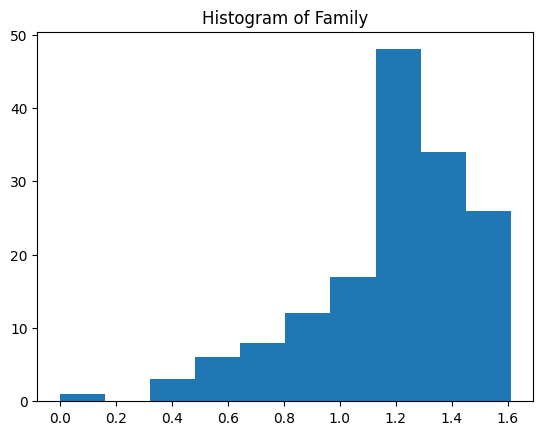

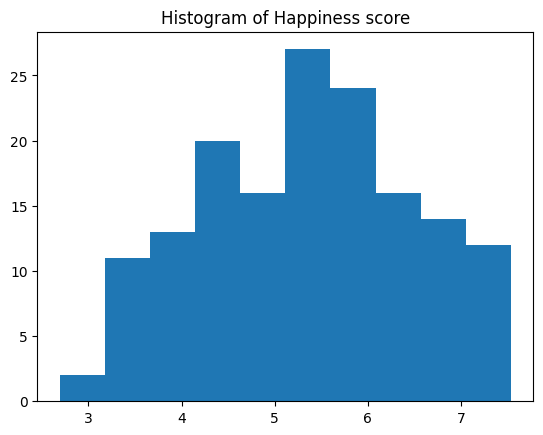

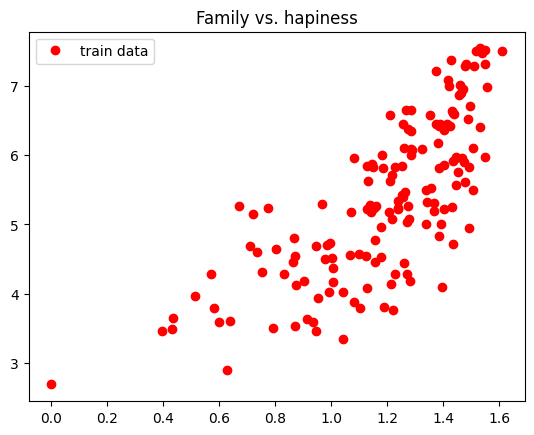

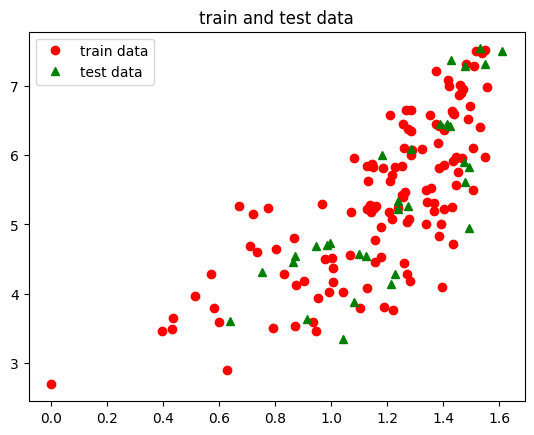

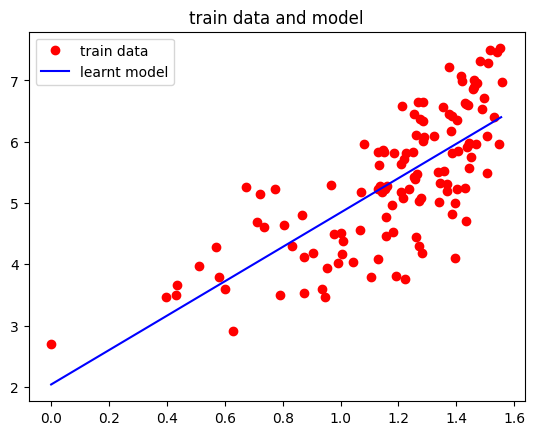

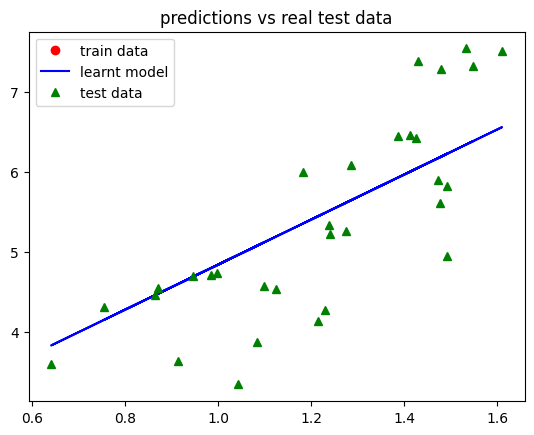

prediction error (manual):  0.6051231125473607
prediction error (tool):  0.6051231125473606


In [6]:
import csv 
import os  
import matplotlib.pyplot as plt  
import numpy as np 
from sklearn import linear_model  
from sklearn.metrics import mean_squared_error 
from mpl_toolkits.mplot3d import Axes3D  

# Functie pentru a incarca datele din CSV 
def loadData(fileName, inputVariabName1, inputVariableName2, outputVariabName):
    data = []
    dataNames = []
    with open(fileName) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                dataNames = row
            else:
                data.append(row)
            line_count += 1
    
    # Gasim indicii coloanelor
    selectedVariable = dataNames.index(inputVariabName1)
    selectedVariable2 = dataNames.index(inputVariableName2)
    selectedOutput = dataNames.index(outputVariabName)
    
    # Extragem valorile ca siruri initial, pentru a gestiona celulele goale
    raw_inputs = [data[i][selectedVariable] for i in range(len(data))]
    raw_inputs2 = [data[i][selectedVariable2] for i in range(len(data))]
    raw_outputs = [data[i][selectedOutput] for i in range(len(data))]
    
    # Convertim in float si calculam media, ignorand celulele goale
    inputs = [float(x) if x != "" else None for x in raw_inputs]
    inputs2 = [float(x) if x != "" else None for x in raw_inputs2]
    outputs = [float(x) if x != "" else None for x in raw_outputs]
    
    # Calculam media doar pentru valorile nenule
    mean_inputs = sum(x for x in inputs if x is not None) / len([x for x in inputs if x is not None])
    mean_inputs2 = sum(x for x in inputs2 if x is not None) / len([x for x in inputs2 if x is not None])
    mean_outputs = sum(x for x in outputs if x is not None) / len([x for x in outputs if x is not None])
    
    # Inlocuim None (celulele goale) cu media
    inputs = [mean_inputs if x is None else x for x in inputs]
    inputs2 = [mean_inputs2 if x is None else x for x in inputs2]
    outputs = [mean_outputs if x is None else x for x in outputs]
    
    return inputs, inputs2, outputs

# Functie pentru a seta folderul si calea catre fisierul curent
def setFilePath():
    cDir = os.getcwd()
    filePath = os.path.join(cDir, '../Data', 'v3_world-happiness-report-2017.csv')
    return filePath

# Functie pentru a incarca si potrivi datele
def loadAndMatchData(filePath):
    inputs, inputs2, outputs = loadData(filePath, 'Economy..GDP.per.Capita.', 'Freedom', 'Happiness.Score')
    print('in: ', inputs[:5])
    print('in2: ', inputs2[:5])
    print('out: ', outputs[:5])
    return inputs, inputs2, outputs

# Functie pentru a plota histogramele
def plotDataHistogram(x, variableName):
    n, bins, patches = plt.hist(x, 10)
    plt.title('Histograma ' + variableName)
    plt.show()

# Functie de creare a graficelor de dispersie
def plotData(x1, y1, x2 = None, y2 = None, x3 = None, y3 = None, title = None):
    plt.plot(x1, y1, 'ro', label = 'date de antrenament')
    if (x2):
        plt.plot(x2, y2, 'b-', label = 'model invatat')
    if (x3):
        plt.plot(x3, y3, 'g^', label = 'date de test')
    plt.title(title)
    plt.legend()
    plt.show()

# Functie pentru a imparti datele in antrenament si testare
def splitData(inputs, inputs2, outputs):
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    validationSample = [i for i in indexes if not i in trainSample]
    trainInputs = [inputs[i] for i in trainSample]
    trainInputs2 = [inputs2[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    validationInputs = [inputs[i] for i in validationSample]
    validationInputs2 = [inputs2[i] for i in validationSample]
    validationOutputs = [outputs[i] for i in validationSample]
    return trainInputs, trainInputs2, trainOutputs, validationInputs, validationInputs2, validationOutputs

# Functie pentru a antrena modelul de regresie liniara
def trainModel(trainInputs, trainInputs2, trainOutputs):
    xx = [[el, el2] for el, el2 in zip(trainInputs, trainInputs2)]
    regressor = linear_model.LinearRegression()
    regressor.fit(xx, trainOutputs)
    return regressor

# Functie pentru a crea puncte pentru afisarea modelului invatat
def createModelPoints(trainInputs, trainInputs2, w0, w1, w2):
    noOfPoints = 1000
    xref = []
    xref2 = []
    val1 = min(trainInputs)
    val2 = min(trainInputs2)
    step1 = (max(trainInputs) - min(trainInputs)) / noOfPoints
    step2 = (max(trainInputs2) - min(trainInputs2)) / noOfPoints

    for i in range(1, noOfPoints):
        xref.append(val1)
        xref2.append(val2)
        val1 += step1
        val2 += step2
    
    yref = [w0 + w1 * el1 + w2 * el2 for el1, el2 in zip(xref, xref2)]
    return xref, xref2, yref

# Functie pentru a face predictii pentru datele de testare
def makePredictions(regressor, validationInputs, validationInputs2):
    computedValidationOutputs = regressor.predict([[x1, x2] for x1, x2 in zip(validationInputs, validationInputs2)])
    return computedValidationOutputs

# Functie pentru a calcula eroarea manual
def calculateManualError(computedValidationOutputs, validationOutputs):
    error = 0.0
    for t1, t2 in zip(computedValidationOutputs, validationOutputs):
        error += (t1 - t2) ** 2
    error = error / len(validationOutputs)
    return error

# Functie pentru a crea graficul 3D
def create3DPlot(trainInputs, trainInputs2, trainOutputs, w0, w1, w2):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(trainInputs, trainInputs2, trainOutputs, c='r', marker='o', label='Date de antrenament')
    
    X = np.linspace(min(trainInputs), max(trainInputs), 100)
    Y = np.linspace(min(trainInputs2), max(trainInputs2), 100)
    X, Y = np.meshgrid(X, Y)
    Z = w0 + w1 * X + w2 * Y
    
    ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, color='b', label='Model Invatat')
    
    ax.set_xlabel('PIB pe cap de locuitor')
    ax.set_ylabel('Libertate')
    ax.set_zlabel('Scor de fericire')
    ax.set_title('Relatia dintre PIB, Libertate si Fericire')
    
    plt.savefig("3d_happiness_plot.png")

# Executia principala
filePath = setFilePath()
inputs, inputs2, outputs = loadAndMatchData(filePath)

# Afisam histogramele pentru variabilele de intrare si iesire
plotDataHistogram(inputs, 'PIB')  
plotDataHistogram(inputs2, 'Libertate')  
plotDataHistogram(outputs, 'Scor fericire')  

# Impartim datele in seturi de antrenament si testare
trainInputs, trainInputs2, trainOutputs, validationInputs, validationInputs2, validationOutputs = splitData(inputs, inputs2, outputs)  

# Afisam datele de antrenament si testare intr-un grafic de dispersie
plotData(trainInputs2, trainOutputs, [], [], validationInputs2, validationOutputs, "date antrenament si testare") 

# Antrenam modelul de regresie liniara
regressor = trainModel(trainInputs, trainInputs2, trainOutputs)  
w0, w1, w2 = regressor.intercept_, regressor.coef_[0], regressor.coef_[1]  

# Generam puncte pentru a afisa modelul invatat
xref, xref2, yref = createModelPoints(trainInputs, trainInputs2, w0, w1, w2)  
plotData(trainInputs, trainOutputs, xref, yref, [], [], title="date antrenament si model")  

# Facem predictii pentru datele de testare
computedValidationOutputs = makePredictions(regressor, validationInputs, validationInputs2)  
plotData([], [], validationInputs, computedValidationOutputs, validationInputs, validationOutputs, "predictii vs date reale test")   

# Calculam eroarea de predictie manual
error_manual = calculateManualError(computedValidationOutputs, validationOutputs)  
print("eroare predictie (manual): ", error_manual)  

# Calculam eroarea de predictie cu tool
error_tool = mean_squared_error(validationOutputs, computedValidationOutputs)  

print("eroare predictie (unealta): ", error_tool)  
# Cream si salvam graficul 3D
create3DPlot(trainInputs, trainInputs2, trainOutputs, w0, w1, w2) 